# 04: Amazon Forecast model

The dataset prepared in 01 is now used with Amazon Forecast.  The below implementation follows AWS Amazon Forecast tutorial from [[3]](https://github.com/aws-samples/amazon-forecast-samples) (see references at the end of the notebook)

The model used is DeepAR+ from Amazon

Here's an overview of the steps:

<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/forecast_overview_steps.png" width="98%">



## Table Of Contents
* Step 1: Setup Amazon Forecast
* Step 2: Prepare the Datasets
* Step 3: Create the Dataset Group and Dataset
* Step 4: Create the Target Time Series Data Import Job
* Next Steps / TODO: see next notebook 05

For more informations about APIs, please check the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)

## Step 1: Setup Amazon Forecast<a class="anchor" id="setup"></a>

NB: see dependencies below:  boto3, s3fs;

util is provided with the repo

This section also sets up the permissions and relevant endpoints.

In [1]:
!pip install boto3 --upgrade

     |████████████████████████████████| 131 kB 2.7 MB/s 
     |████████████████████████████████| 7.8 MB 4.1 MB/s 
     |████████████████████████████████| 79 kB 6.4 MB/s 
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.109
    Uninstalling botocore-1.20.109:
      Successfully uninstalled botocore-1.20.109
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.4.2
    Uninstalling s3transfer-0.4.2:
      Successfully uninstalled s3transfer-0.4.2
  Attempting uninstall: boto3
    Found existing installation: boto3 1.17.109
    Uninstalling boto3-1.17.109:
      Successfully uninstalled boto3-1.17.109


In [92]:
import sys
import os
import pandas as pd

# importing forecast notebook utility from notebooks/common directory
#sys.path.insert( 0, os.path.abspath("../../common") )
import util

%reload_ext autoreload
import boto3
import s3fs

Configure the S3 bucket name and region name for this lesson.

- If you don't have an S3 bucket, create it first on S3. 
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [98]:
region = 'eu-central-1'
bucket_name = 'forecast-test-0'

In [88]:
# Connect API session
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

<b>Create IAM Role for Forecast</b> <br>
Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. In the sample notebooks, we use the get_or_create_iam_role() utility function to create an IAM role. Please refer to "notebooks/common/util/fcst_utils.py" for implementation.

In [89]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-Basic"
print(f"Creating Role {role_name} ...")
role_arn = util.get_or_create_iam_role( role_name = role_name )

# echo user inputs without account
print(f"Success! Created role arn = {role_arn.split('/')[1]}")

Creating Role ForecastNotebookRole-Basic ...
The role ForecastNotebookRole-Basic exists, ignore to create it
Attaching policies
Waiting for a minute to allow IAM role policy attachment to propagate
Done.
Success! Created role arn = ForecastNotebookRole-Basic


In [95]:
def create_bucket(bucket_name, region=None):
    """Create an S3 bucket in a specified region
    If a region is not specified, the bucket is created in the S3 default
    region (us-east-1).
    :param bucket_name: Bucket to create
    :param region: String region to create bucket in, e.g., 'us-west-2'
    :return: True if bucket created, else False
    """
    try:
        if region is None:
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        elif region == "us-east-1":
            s3_client = boto3.client('s3')
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client = boto3.client('s3', region_name=region)
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name,
                                    CreateBucketConfiguration=location)
    except Exception as e:
        print(e)
        return False
    return True

In [99]:

account_id = boto3.client('sts').get_caller_identity().get('Account')

# create unique S3 bucket for saving your own data

if create_bucket(bucket_name, region=region):
    print(f"Success! Created bucket {bucket_name}")

Success! Created bucket forecast-test-0


The last part of the setup process is to validate that your account can communicate with Amazon Forecast, the cell below does just that.

In [100]:
# check you can communicate with Forecast API session
forecast.list_predictors()

{'Predictors': [],
 'ResponseMetadata': {'RequestId': '39301b9c-ef3c-47d0-b872-0b4395c4af04',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Jul 2021 12:42:03 GMT',
   'x-amzn-requestid': '39301b9c-ef3c-47d0-b872-0b4395c4af04',
   'content-length': '17',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Step 2: Prepare the Datasets

Dataset -- as described in Notebook 01.

NB: Python Picle Format (Pandas `read_pickle`) night not work from Python 3.7 to 3.8,  

Need to install and import picle5:

conda install -c conda-forge pickle5

In [12]:
import pickle5 as pickle

In [13]:
#test2 = pd.read_pickle("weather_VAR_SOF1")

test2 = pickle.load( open( "weather_VAR_SOF1", "rb" ) )

In [14]:
test2.head()

Varna                Sofia              Various     
                      Temp, C     SLP, hPa Temp, C     SLP, hPa     Day Hour
Date_Time                                                                   
1973-01-01 00:00:00 -2.780000  1046.300000   -3.89  1047.100000       1    0
1973-01-01 01:00:00 -3.520000  1046.266667   -3.89  1047.133333       1    1
1973-01-01 02:00:00 -4.260000  1046.233333   -3.89  1047.166667       1    2
1973-01-01 03:00:00 -5.000000  1046.200000   -3.89  1047.200000       1    3
1973-01-01 04:00:00 -3.981667  1046.566667   -5.00  1047.466667       1    4

In [ ]:
# df = pd.read_csv("../../common/data/item-demand-time.csv", dtype = object, names=['timestamp','value','item'])
# df.head(3)

<AxesSubplot:xlabel='Date_Time'>

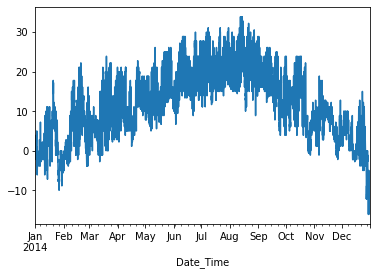

In [15]:
test2["Sofia"]["Temp, C"]['2014-01':'2014-12'].plot()

<AxesSubplot:xlabel='Date_Time'>

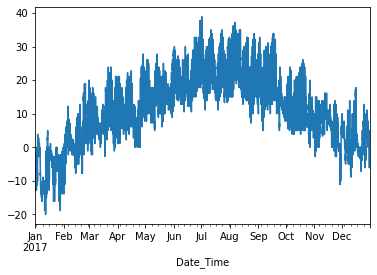

In [16]:
test2["Sofia"]["Temp, C"]['2017-01':'2017-12'].plot()

<AxesSubplot:xlabel='Date_Time'>

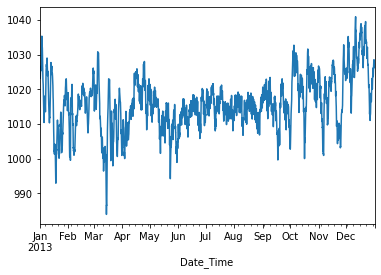

In [17]:
test2["Sofia"]["SLP, hPa"]['2013-01':'2013-12'].plot()

<AxesSubplot:xlabel='Date_Time'>

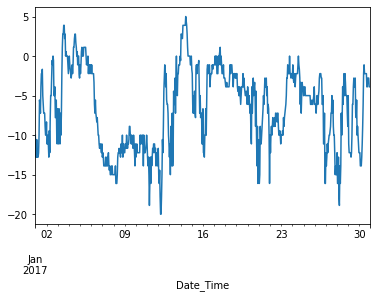

In [18]:
test2["Sofia"]["Temp, C"]['2017-01-01':'2017-01-30'].plot()

...it was cold indeed, I remember :)

In [19]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 401784 entries, 1973-01-01 00:00:00 to 2018-11-01 23:00:00
Freq: 60T
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   (Varna, Temp, C)   401784 non-null  float64
 1   (Varna, SLP, hPa)  401784 non-null  float64
 2   (Sofia, Temp, C)   401784 non-null  float64
 3   (Sofia, SLP, hPa)  401784 non-null  float64
 4   (Various, Day)     401784 non-null  int64  
 5   (Various, Hour)    401784 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 31.5 MB


In [36]:
test2.index

DatetimeIndex(['1973-01-01 00:00:00', '1973-01-01 01:00:00',
               '1973-01-01 02:00:00', '1973-01-01 03:00:00',
               '1973-01-01 04:00:00', '1973-01-01 05:00:00',
               '1973-01-01 06:00:00', '1973-01-01 07:00:00',
               '1973-01-01 08:00:00', '1973-01-01 09:00:00',
               ...
               '2018-11-01 14:00:00', '2018-11-01 15:00:00',
               '2018-11-01 16:00:00', '2018-11-01 17:00:00',
               '2018-11-01 18:00:00', '2018-11-01 19:00:00',
               '2018-11-01 20:00:00', '2018-11-01 21:00:00',
               '2018-11-01 22:00:00', '2018-11-01 23:00:00'],
              dtype='datetime64[ns]', name='Date_Time', length=401784, freq='60T')

In [37]:
print(f"min timestamp = {test2.index.min()}")
print(f"max timestamp = {test2.index.max()}")


min timestamp = 1973-01-01 00:00:00
max timestamp = 2018-11-01 23:00:00


In [54]:
SOF_t_only= test2.iloc[:, 2]

In [63]:
SOF_T = SOF_t_only.to_frame()

In [66]:
SOF_T["item_id"] = "Sofia"

In [71]:
SOF_T

,Date_Time,Sofia,item_id
,,"Temp, C",
0,1973-01-01 00:00:00,-3.89,Sofia
1,1973-01-01 01:00:00,-3.89,Sofia
2,1973-01-01 02:00:00,-3.89,Sofia
3,1973-01-01 03:00:00,-3.89,Sofia
4,1973-01-01 04:00:00,-5.00,Sofia
...,...,...,...
401779,2018-11-01 19:00:00,17.22,Sofia
401780,2018-11-01 20:00:00,17.22,Sofia
401781,2018-11-01 21:00:00,17.78,Sofia


In [70]:
SOF_T.reset_index(inplace=True)

In [80]:
#test2.iloc[:, [2]].to_csv('t2.csv', header= False)

SOF_T.to_csv('t1.csv', header=False, index=False)

In [43]:
test2["Sofia"]["Temp, C"]

Date_Time
1973-01-01 00:00:00    -3.89
1973-01-01 01:00:00    -3.89
1973-01-01 02:00:00    -3.89
1973-01-01 03:00:00    -3.89
1973-01-01 04:00:00    -5.00
                       ...  
2018-11-01 19:00:00    17.22
2018-11-01 20:00:00    17.22
2018-11-01 21:00:00    17.78
2018-11-01 22:00:00    16.11
2018-11-01 23:00:00    16.11
Freq: 60T, Name: Temp, C, Length: 401784, dtype: float64

In [49]:
test2.iloc[:, [2]]

,Sofia
,"Temp, C"
Date_Time,
1973-01-01 00:00:00,-3.89
1973-01-01 01:00:00,-3.89
1973-01-01 02:00:00,-3.89
1973-01-01 03:00:00,-3.89
1973-01-01 04:00:00,-5.00
...,...
2018-11-01 19:00:00,17.22
2018-11-01 20:00:00,17.22


Notice in the output above there are 3 columns of data:

1. The Timestamp
1. A Value
1. An Item ID

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present.



In [102]:
# save an item_id for querying later
item_id = "Sofia"

Now export them to CSV files and place them into your `data` folder.

At this time the data is ready to be sent to S3 where Forecast will use it later. The following cells will upload the data to S3.

In [101]:
key="t1.csv"

boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file("t1.csv")

## Step 3: Create the Dataset Group and Dataset <a class="anchor" id="DataSet"></a>

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast. Since data files are imported headerless, it is important to define a schema for your data.

More details about `Domain` and dataset type can be found on the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html) . For this example, we are using [CUSTOM](https://docs.aws.amazon.com/forecast/latest/dg/custom-domain.html) domain with 3 required attributes `timestamp`, `target_value` and `item_id`.


Next, you need to make some choices. 
<ol>
    <li><b>How many time units do you want to forecast?</b>. For example, if your time unit is Hour, then if you want to forecast out 1 week, that would be 24*7 = 168 hours, so answer = 168. </li>
    <li><b>What is the time granularity for your data?</b>. For example, if your time unit is Hour, answer = "H". </li>
    <li><b>Think of a name you want to give this project (Dataset Group name)</b>, so all files will have the same names.  You should also use this same name for your Forecast DatasetGroup name, to set yourself up for reproducibility. </li>
    </ol>

In [103]:
# what is your forecast horizon in number time units you've selected?
# e.g. if you're forecasting in months, how many months out do you want a forecast?
FORECAST_LENGTH = 72

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|H|30min|15min|10min|5min|1min$ 
DATASET_FREQUENCY = "H"
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

# What name do you want to give this project?  
# We will use this same name for your Forecast Dataset Group name.
PROJECT = 'sof_temperature_forecast'
DATA_VERSION = 1

### Create the Dataset Group

In this task, we define a container name or Dataset Group name, which will be used to keep track of Dataset import files, schema, and all Forecast results which go together.


In [104]:
dataset_group = f"{PROJECT}_{DATA_VERSION}"
print(f"Dataset Group Name = {dataset_group}")

Dataset Group Name = sof_temperature_forecast_1


In [105]:
dataset_arns = []
create_dataset_group_response = \
    forecast.create_dataset_group(Domain="CUSTOM",
                                  DatasetGroupName=dataset_group,
                                  DatasetArns=dataset_arns)

In [106]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [107]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

{'DatasetGroupName': 'sof_temperature_forecast_1',
 'DatasetGroupArn': 'arn:aws:forecast:eu-central-1:574930355514:dataset-group/sof_temperature_forecast_1',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 7, 29, 15, 53, 43, 499000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 7, 29, 15, 53, 43, 499000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'fa2e0779-d279-49ce-a242-62d40f53f2b8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Jul 2021 12:53:49 GMT',
   'x-amzn-requestid': 'fa2e0779-d279-49ce-a242-62d40f53f2b8',
   'content-length': '278',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Create the Schema

In [108]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
ts_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

### Create the Dataset

In [109]:
ts_dataset_name = f"{PROJECT}_{DATA_VERSION}"
print(ts_dataset_name)

sof_temperature_forecast_1


In [110]:
response = \
forecast.create_dataset(Domain="CUSTOM",
                        DatasetType='TARGET_TIME_SERIES',
                        DatasetName=ts_dataset_name,
                        DataFrequency=DATASET_FREQUENCY,
                        Schema=ts_schema
                       )

In [111]:
ts_dataset_arn = response['DatasetArn']

In [112]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

{'DatasetArn': 'arn:aws:forecast:eu-central-1:574930355514:dataset/sof_temperature_forecast_1',
 'DatasetName': 'sof_temperature_forecast_1',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 7, 29, 15, 54, 45, 252000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 7, 29, 15, 54, 45, 252000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '4e3df9cd-3726-4841-bff7-01dab141164a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Jul 2021 12:54:48 GMT',
   'x-amzn-requestid': '4e3df9cd-3726-4841-bff7-01dab141164a',
   'content-length': '516',
   'connection': 'keep-alive'}

### Update the dataset group with the datasets we created
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [113]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': 'bfe51988-52e5-40dc-8e04-7d6832c5962a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Jul 2021 12:54:59 GMT',
   'x-amzn-requestid': 'bfe51988-52e5-40dc-8e04-7d6832c5962a',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Step 4: Create a Target Time Series Dataset Import Job <a class="anchor" id="DataImport"></a>


Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecaast.

In [114]:
# Recall path to your data
ts_s3_data_path = "s3://"+bucket_name+"/"+key
print(f"S3 URI for your data file = {ts_s3_data_path}")

S3 URI for your data file = s3://forecast-test-0/t1.csv


In [118]:
ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

In [119]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']
ts_dataset_import_job_arn

'arn:aws:forecast:eu-central-1:574930355514:dataset-import-job/sof_temperature_forecast_1/sof_temperature_forecast_1'

### Stop the data import

Possibly during fine-tuning development, you'll accidentally upload data before you're ready.  If you don't want to wait for the data upload and processing, there is a handy "Stop API" call.


In [ ]:
# StopResource
stop_ts_dataset_import_job_arn = forecast.stop_resource(ResourceArn=ts_dataset_import_job_arn)

In [ ]:
# Delete the target time series dataset import job
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))

### Do the data import again

Maybe you fixed something you forgot before, and now you're ready to really upload the data for Forecast ingestion and processing.

In [ ]:
ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']
ts_dataset_import_job_arn

Check the status of dataset, when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on the data size. It can take 10 mins to be **ACTIVE**. This process will take 5 to 10 minutes.

In [120]:
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

CREATE_IN_PROGRESS ............................................
ACTIVE 


In [121]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)

{'DatasetImportJobName': 'sof_temperature_forecast_1',
 'DatasetImportJobArn': 'arn:aws:forecast:eu-central-1:574930355514:dataset-import-job/sof_temperature_forecast_1/sof_temperature_forecast_1',
 'DatasetArn': 'arn:aws:forecast:eu-central-1:574930355514:dataset/sof_temperature_forecast_1',
 'TimestampFormat': 'yyyy-MM-dd hh:mm:ss',
 'UseGeolocationForTimeZone': False,
 'DataSource': {'S3Config': {'Path': 's3://forecast-test-0/t1.csv',
   'RoleArn': 'arn:aws:iam::574930355514:role/ForecastNotebookRole-Basic'}},
 'FieldStatistics': {'item_id': {'Count': 401784,
   'CountDistinct': 1,
   'CountNull': 0,
   'CountLong': 401784,
   'CountDistinctLong': 1,
   'CountNullLong': 0},
  'target_value': {'Count': 401784,
   'CountDistinct': 12756,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '-25.0',
   'Max': '41.11',
   'Avg': 10.1715268852146,
   'Stddev': 9.428677566143127,
   'CountLong': 401784,
   'CountDistinctLong': 12756,
   'CountNullLong': 0,
   'CountNanLong': 0},
  'timestamp': 

## Next Steps<a class="anchor" id="nextSteps"></a>

At this point the data was successfully imported into Amazon Forecast and now it is time to build the model. 
Save some variables fir use between the notebooks first.

In [122]:
# Now save your choices for the next notebook 
%store item_id
%store PROJECT
%store DATA_VERSION
%store FORECAST_LENGTH
%store DATASET_FREQUENCY
%store TIMESTAMP_FORMAT
%store ts_dataset_import_job_arn
%store ts_dataset_arn
%store dataset_group_arn
%store role_arn
%store bucket_name
%store region
%store key

Stored 'item_id' (str)
Stored 'PROJECT' (str)
Stored 'DATA_VERSION' (int)
Stored 'FORECAST_LENGTH' (int)
Stored 'DATASET_FREQUENCY' (str)
Stored 'TIMESTAMP_FORMAT' (str)
Stored 'ts_dataset_import_job_arn' (str)
Stored 'ts_dataset_arn' (str)
Stored 'dataset_group_arn' (str)
Stored 'role_arn' (str)
Stored 'bucket_name' (str)
Stored 'region' (str)
Stored 'key' (str)


In [ ]:
# %store -r

# # Print your choices from first notebook
# print(f"item_id = {item_id}")
# print(f"project = {PROJECT}")
# print(f"data_version = {DATA_VERSION}")
# print(f"Forecast length = {FORECAST_LENGTH}")
# print(f"Dataset frequency = {DATASET_FREQUENCY}")
# print(f"Timestamp format = {TIMESTAMP_FORMAT}")
# print(f"dataset_group_arn = {dataset_group_arn}")
# print(f"role_arn = {role_arn}")
# %store -r bucket_name
# print(f"bucket_name = {bucket_name}")
# %store -r region
# print(f"region = {region}")

In [123]:
# check you can communicate with Forecast API session
forecast.list_predictors()

{'Predictors': [],
 'ResponseMetadata': {'RequestId': '1235a304-d730-4bb1-8f6b-07e7682decd8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Jul 2021 13:07:52 GMT',
   'x-amzn-requestid': '1235a304-d730-4bb1-8f6b-07e7682decd8',
   'content-length': '17',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [124]:
# Which algorithm do you want to use?  Choices are:
# 1. Choose PerformAutoML=True if you want to let Amazon Forecast choose a recipe automatically.  
# 2. If you know which recipe you want, the next level of automation is PerformHPO=True.
# 3. Finally, you can specify exactly which recipe and enter your own hyperparameter values
# https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html

algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

Predictor Name = sof_temperature_forecast_1_deep_ar_plus


In [125]:
create_predictor_response = \
    forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                              AlgorithmArn=algorithm_arn_deep_ar_plus,
                              ForecastHorizon=FORECAST_LENGTH,
                              PerformAutoML=False,
                              PerformHPO=False,
                              InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                              FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY}
                             )

In [126]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [127]:

status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
assert status

CREATE_IN_PROGRESS .........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ACTIVE 


In [128]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

{'PredictorArn': 'arn:aws:forecast:eu-central-1:574930355514:predictor/sof_temperature_forecast_1_deep_ar_plus',
 'PredictorName': 'sof_temperature_forecast_1_deep_ar_plus',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
 'ForecastHorizon': 72,
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PerformAutoML': False,
 'PerformHPO': False,
 'TrainingParameters': {'context_length': '144',
  'epochs': '500',
  'learning_rate': '1E-3',
  'learning_rate_decay': '0.5',
  'likelihood': 'student-t',
  'max_learning_rate_decays': '0',
  'num_averaged_models': '1',
  'num_cells': '40',
  'num_layers': '2',
  'prediction_length': '72'},
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 72},
 'InputDataConfig': {'DatasetGroupArn': 'arn:aws:forecast:eu-central-1:574930355514:dataset-group/sof_temperature_forecast_1'},
 'FeaturizationConfig': {'ForecastFrequency': 'H',
  'Featurizations': [{'AttributeName': 'target_value',
    'FeaturizationPipeline': [{'Featur

### Get Predictor Error Metrics from Backtesting 

After creating the predictors, we can query the forecast accuracy given by the backtest scenario and have a quantitative understanding of the performance of the algorithm. Such a process is iterative in nature during model development. When an algorithm with satisfying performance is found, the customer can deploy the predictor into a production environment, and query the forecasts for a particular item to make business decisions. The figure below shows a sample plot of different quantile forecasts of a predictor.

In [129]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 2.8056032983401455,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.0640613829623758},
       {'Quantile': 0.5, 'LossValue': 0.13991594321957088},
       {'Quantile': 0.1, 'LossValue': 0.10678413658910633}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.14845030024660774,
        'RMSE': 2.8056032983401455}]}},
    {'TestWindowStart': datetime.datetime(2018, 10, 30, 2, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2018, 11, 2, 2, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 2.8056032983401455,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.0640613829623758},
       {'Quantile': 0.5, 'LossValue': 0.13991594321957088},
       {'Quantile': 0.1, 'LossValue': 0.10678413658910633}],

### Create a Forecast

In [130]:
forecast_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

Predictor Name = sof_temperature_forecast_1_deep_ar_plus


In [131]:
# create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
#                                                   PredictorArn=predictor_arn)
# forecast_arn = create_forecast_response['ForecastArn']

create_forecast_response_deep_ar = \
    forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                             PredictorArn=predictor_arn_deep_ar)

forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [132]:
status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar))
assert status

CREATE_PENDING .
CREATE_IN_PROGRESS ................................................................................................
ACTIVE 


In [133]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

{'ForecastArn': 'arn:aws:forecast:eu-central-1:574930355514:forecast/sof_temperature_forecast_1_deep_ar_plus',
 'ForecastName': 'sof_temperature_forecast_1_deep_ar_plus',
 'ForecastTypes': ['0.1', '0.5', '0.9'],
 'PredictorArn': 'arn:aws:forecast:eu-central-1:574930355514:predictor/sof_temperature_forecast_1_deep_ar_plus',
 'DatasetGroupArn': 'arn:aws:forecast:eu-central-1:574930355514:dataset-group/sof_temperature_forecast_1',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2021, 7, 29, 21, 57, 48, 160000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2021, 7, 29, 22, 14, 22, 326000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '9b374fe8-d03e-462a-a382-a0f18533c4d8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 29 Jul 2021 19:15:04 GMT',
   'x-amzn-requestid': '9b374fe8-d03e-462a-a382-a0f18533c4d8',
   'content-length': '505',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### Query the Forecast 

In [134]:
item_id

'Sofia'

In [135]:
forecast_response_deep = forecastquery.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": item_id})

forecast_response_deep

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2018-11-02T00:00:00',
     'Value': 14.052572250366211},
    {'Timestamp': '2018-11-02T01:00:00', 'Value': 12.349756240844727},
    {'Timestamp': '2018-11-02T02:00:00', 'Value': 11.965265274047852},
    {'Timestamp': '2018-11-02T03:00:00', 'Value': 10.911174774169922},
    {'Timestamp': '2018-11-02T04:00:00', 'Value': 10.22409439086914},
    {'Timestamp': '2018-11-02T05:00:00', 'Value': 9.86082935333252},
    {'Timestamp': '2018-11-02T06:00:00', 'Value': 10.986167907714844},
    {'Timestamp': '2018-11-02T07:00:00', 'Value': 12.510345458984375},
    {'Timestamp': '2018-11-02T08:00:00', 'Value': 13.758042335510254},
    {'Timestamp': '2018-11-02T09:00:00', 'Value': 15.84775161743164},
    {'Timestamp': '2018-11-02T10:00:00', 'Value': 16.88087272644043},
    {'Timestamp': '2018-11-02T11:00:00', 'Value': 17.3114013671875},
    {'Timestamp': '2018-11-02T12:00:00', 'Value': 17.400869369506836},
    {'Timestamp': '2018-11-02T13:00:00', 'Val

...these seems quite off for November...


In [136]:
%store forecast_arn_deep_ar
%store predictor_arn_deep_ar

Stored 'forecast_arn_deep_ar' (str)
Stored 'predictor_arn_deep_ar' (str)


### Evaluating the Forecast

So far you have prepared your data, and generated your first Forecast. Now is the time to pull down the predictions from this Predictor, and compare them to the actual observed values. This will let us know the impact of accuracy based on the Forecast.

You can extend the approaches here to compare multiple models or predictors and to determine the impact of improved accuracy on your use case.

Overview:

- Setup
- Obtaining a Prediction
- Plotting the Actual Results
- Plotting the Prediction
- Comparing the Prediction to Actual Results


In [137]:
import json
import time
import dateutil.parser

In [ ]:

#%store -r

In [138]:

actual_df = pd.read_csv("t1.csv", names=['timestamp','value','item'])
actual_df.head()

,timestamp,value,item
0,1973-01-01 00:00:00,-3.89,Sofia
1,1973-01-01 01:00:00,-3.89,Sofia
2,1973-01-01 02:00:00,-3.89,Sofia
3,1973-01-01 03:00:00,-3.89,Sofia
4,1973-01-01 04:00:00,-5.00,Sofia


In [145]:
actual_df.tail()

,timestamp,value,item
401779,2018-11-01 19:00:00,17.22,Sofia
401780,2018-11-01 20:00:00,17.22,Sofia
401781,2018-11-01 21:00:00,17.78,Sofia
401782,2018-11-01 22:00:00,16.11,Sofia
401783,2018-11-01 23:00:00,16.11,Sofia


In [146]:
actual_df = actual_df.tail(72)

In [157]:
actual_df.drop(columns="item")

,timestamp,value
401712,2018-10-30 00:00:00,12.22
401713,2018-10-30 01:00:00,8.89
401714,2018-10-30 02:00:00,8.89
401715,2018-10-30 03:00:00,10.56
401716,2018-10-30 04:00:00,8.89
...,...,...
401779,2018-11-01 19:00:00,17.22
401780,2018-11-01 20:00:00,17.22
401781,2018-11-01 21:00:00,17.78
401782,2018-11-01 22:00:00,16.11


In [158]:
actual_df.shape

(72, 3)

<AxesSubplot:>

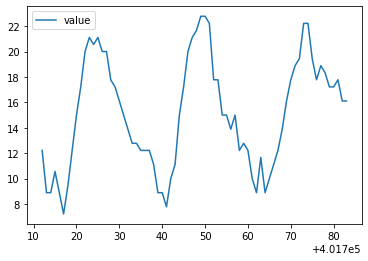

In [159]:
actual_df.plot()

In [143]:

# Generate DF 
prediction_df_p10 = pd.DataFrame.from_dict(forecast_response_deep['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

,Timestamp,Value
0,2018-11-02T00:00:00,14.052572
1,2018-11-02T01:00:00,12.349756
2,2018-11-02T02:00:00,11.965265
3,2018-11-02T03:00:00,10.911175
4,2018-11-02T04:00:00,10.224094


<AxesSubplot:>

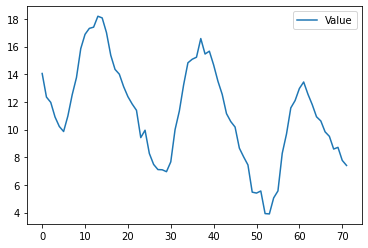

In [144]:

# Plot
prediction_df_p10.plot()

In [151]:
prediction_df_p10.shape

(72, 2)

In [161]:
prediction_df_p50 = pd.DataFrame.from_dict(forecast_response_deep['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecast_response_deep['Forecast']['Predictions']['p90'])

In [163]:

# creating a new dataframe to house our content, here source will be which dataframe it came from
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

In [164]:
for index, row in actual_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)

In [165]:
# To show the new dataframe
results_df.head()

,timestamp,value,source
0,2018-10-30 00:00:00,12.22,actual
1,2018-10-30 01:00:00,8.89,actual
2,2018-10-30 02:00:00,8.89,actual
3,2018-10-30 03:00:00,10.56,actual
4,2018-10-30 04:00:00,8.89,actual


In [166]:
# Now add the P10, P50, and P90 Values
for index, row in prediction_df_p10.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

In [167]:
results_df

,timestamp,value,source
0,2018-10-30 00:00:00,12.220000,actual
1,2018-10-30 01:00:00,8.890000,actual
2,2018-10-30 02:00:00,8.890000,actual
3,2018-10-30 03:00:00,10.560000,actual
4,2018-10-30 04:00:00,8.890000,actual
...,...,...,...
283,2018-11-04 19:00:00,21.254557,p90
284,2018-11-04 20:00:00,19.984167,p90
285,2018-11-04 21:00:00,19.784496,p90
286,2018-11-04 22:00:00,18.458773,p90


In [168]:
pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df

source,actual,p10,p50,p90
timestamp,,,,
2018-10-30 00:00:00,12.22,NaN,NaN,NaN
2018-10-30 01:00:00,8.89,NaN,NaN,NaN
2018-10-30 02:00:00,8.89,NaN,NaN,NaN
2018-10-30 03:00:00,10.56,NaN,NaN,NaN
2018-10-30 04:00:00,8.89,NaN,NaN,NaN
...,...,...,...,...
2018-11-04 19:00:00,NaN,9.511445,14.544183,21.254557
2018-11-04 20:00:00,NaN,8.594519,13.675614,19.984167
2018-11-04 21:00:00,NaN,8.717037,13.776693,19.784496


<AxesSubplot:xlabel='timestamp'>

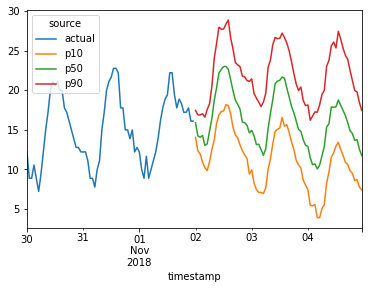

In [169]:
pivot_df.plot()



## References

1. Amazon Forecast resources, [AWS website](https://aws.amazon.com/forecast/resources/)

2. Time Series Forecasting Principles with Amazon Forecast, [Technical Guide](https://d1.awsstatic.com/whitepapers/time-series-forecasting-principles-amazon-forecast.pdf)

3. AWS Samples-- Amazon Forecast Samples [GitHub repo](https://github.com/aws-samples/amazon-forecast-samples)


